#implementing Unet Architecture in python using Keras API for semantic segmentation of images

#Our Steps :
    1) Get Data Ready
    2) Define Custom Data Generator
    3) Define the 3-D U-net Model
    4) Train and Predict

In [1]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
import tensorflow as tf

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('gpu')
print(len(physical_devices))

0


#
There are 4 types of image scans on BraTS 2020 Dataset
        Native (T1)
        Contrast - T1 Weighted
        T2 Weighted 
        Flair (Fluid Attenuated Inversion Recovery)

#
Labels : 
0 - Unlabeled Volume
1 - Necrotic and Non - Enhancing Tumor Core
2 - Peritumoral Edema
3 - Missing
4 - GD Enhancing Tumor


In [3]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from tifffile import imsave

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair)
print('\n')
print(test_image_flair.max())
#Looking at this we get a good idea we need to scale this Image using minmaxscaler

test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair.max())

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


1854.603

[0 1 2 4]
[0 1 2 3]


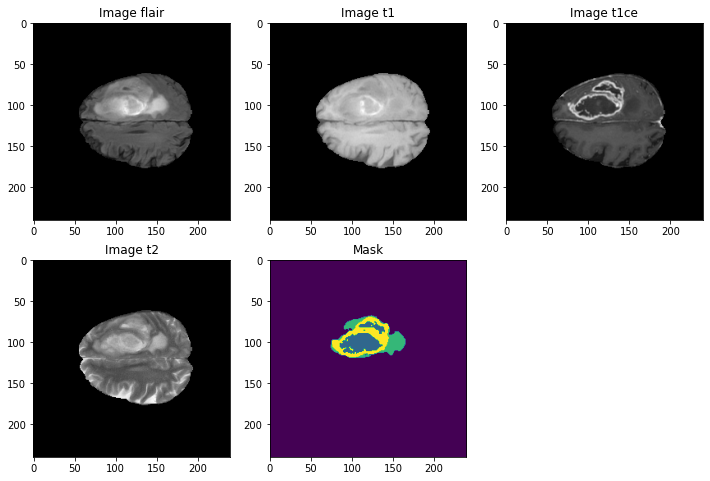

In [6]:
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  
#0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3) as we are not considering (3-Missing)
test_mask[test_mask==4] = 3
#Reassign mask values 4 to 3
print(np.unique(test_mask)) 

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [7]:
#Let us combine flair , t1ce, t2 into 1 image as t1 is unimportant 
#and
#we can feed information of other 3 images to the model easily

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Now we will crop the images and the mask to get a Volume of 128x128x128x3
#and do the same for mask

combined_x=combined_x[56:184, 56:184, 13:141] 

test_mask = test_mask[56:184, 56:184, 13:141]

In [8]:
#saving combined images as a numpy array
np.save('BraTS2020_TrainingData/combined255.npy', combined_x)
my_img=np.load('BraTS2020_TrainingData/combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

In [9]:
#Now, we'll apply the above done operations on the whole dataset

t2_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

print(len(t2_list), len(mask_list), len(t1ce_list), len(flair_list))

369 369 369 369


In [12]:
#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless") 

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

Save Me
Now preparing image and masks number:  162
Save Me
Now preparing image and masks number:  163
Save Me
Now preparing image and masks number:  164
Save Me
Now preparing image and masks number:  165
Save Me
Now preparing image and masks number:  166
Save Me
Now preparing image and masks number:  167
Save Me
Now preparing image and masks number:  168
Save Me
Now preparing image and masks number:  169
Save Me
Now preparing image and masks number:  170
Save Me
Now preparing image and masks number:  171
Save Me
Now preparing image and masks number:  172
Save Me
Now preparing image and masks number:  173
Save Me
Now preparing image and masks number:  174
Save Me
Now preparing image and masks number:  175
Save Me
Now preparing image and masks number:  176
I am useless
Now preparing image and masks number:  177
Save Me
Now preparing image and masks number:  178
Save Me
Now preparing image and masks number:  179
Save Me
Now preparing image and masks number:  180
Save Me
Now preparing imag

Save Me
Now preparing image and masks number:  322
Save Me
Now preparing image and masks number:  323
Save Me
Now preparing image and masks number:  324
I am useless
Now preparing image and masks number:  325
Save Me
Now preparing image and masks number:  326
Save Me
Now preparing image and masks number:  327
Save Me
Now preparing image and masks number:  328
Save Me
Now preparing image and masks number:  329
Save Me
Now preparing image and masks number:  330
Save Me
Now preparing image and masks number:  331
Save Me
Now preparing image and masks number:  332
Save Me
Now preparing image and masks number:  333
Save Me
Now preparing image and masks number:  334
Save Me
Now preparing image and masks number:  335
Save Me
Now preparing image and masks number:  336
Save Me
Now preparing image and masks number:  337
Save Me
Now preparing image and masks number:  338
Save Me
Now preparing image and masks number:  339
Save Me
Now preparing image and masks number:  340
I am useless
Now preparing

In [13]:
import splitfolders

In [15]:
input_folder = 'BraTS2020_TrainingData/input_data_3channels/'
output_folder = 'BraTS2020_TrainingData/input_data_128/'

#dividing training data to training (85%) and validation data (15%).
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.85, .15), group_prefix=None)